# Community Playbook Analysis
Analysis of 1221 community playbooks from various vendors 

## Import relevant modules

In [1]:
# Download spaCy model
!python -m spacy download en_core_web_sm

# Import necessary packages
import pandas as pd
import numpy as np
import re
import string
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import ast
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from collections import Counter

# Set pandas options
pd.options.mode.chained_assignment = None  # default='warn'

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Define stemmer and lemmatizer
pst = PorterStemmer()
lemma = WordNetLemmatizer()

# Define stopwords 
stop_words_custom = ["playbook", "workflow", "story"]
stop_words = set(stopwords.words("english")).union(stop_words_custom)

# Use tqdm 
tqdm.pandas()


  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mail\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mail\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mail\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mail\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mail\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\mail\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_ta

## (0) Define helping classes and functions

### (0.1) Class for clustering (_deprecated_)

In [2]:
class Cluster:
    def preprocess_text(self, text: str, remove_stopwords: bool) -> str:
        # Remove special chars and numbers
        text = re.sub(r"[^A-Za-z1-9]+", " ", text)
        # Remove stopwords and stemmatize
        if remove_stopwords:
            tokens = nltk.word_tokenize(text)
            tokens = [nltk.stem.PorterStemmer().stem(w) for w in tokens if w.lower() not in nltk.corpus.stopwords.words("english")]
            text = " ".join(tokens)
        # Return text in lower case and stripped of whitespaces
        return text.lower().strip()

    def vectorize_strings(self, texts, min_df, max_df):
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=min_df, max_df=max_df, stop_words=["playbook", "workflow", "story"])
        return vectorizer, vectorizer.fit_transform(texts)

    def initialize_kmeans(self, clusters, X):
        # Initialize kmeans with given number of centroids
        kmeans = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1, random_state=42)
        # Fit the model
        kmeans.fit(X)
        # Calculate silhouette score
        s_score = silhouette_score(X, kmeans.labels_)
        # Calculate Calinski-Harabasz score
        c_score = calinski_harabasz_score(X.toarray(), kmeans.labels_)
        # Return scores and cluster labels
        return s_score, c_score, kmeans.labels_

    def initialize_pca(self, X, clusters):
        pca = PCA(n_components=2, random_state=42)
        pca_vecs = pca.fit_transform(X.toarray())
        df_tmp1 = pd.DataFrame(pca_vecs, columns=['x0', 'x1'])
        df_tmp1['cluster'] = clusters
        return df_tmp1

    def get_top_keywords(self, n_terms, vectorizer, clusters, X):
        df_tmp1 = pd.DataFrame(X.todense()).groupby(clusters).mean()
        terms = vectorizer.get_feature_names_out()

        for i, r in df_tmp1.iterrows():
            top_terms = [terms[t] for t in np.argsort(r)[-n_terms:]]
            print(f"\nCluster {i}: {', '.join(top_terms)}")

    def plot_cluster(self, df, plot_title):
        fig, ax = plt.subplots(figsize=(12, 7))
        sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', ax=ax)
        ax.set_xlabel("X0", fontsize=16)
        ax.set_ylabel("X1", fontsize=16)
        if plot_title:
            ax.set_title(plot_title)
        plt.show()

    def cluster_field(self, df, field, num_clusters, min_df, max_df, num_keywords, cluster_mapping=None, plot_title=None):
        # Preprocess text
        df['cleaned'] = df[field].apply(lambda x: self.preprocess_text(str(x), remove_stopwords=True))
        # Vectorize text
        vectorizer, X = self.vectorize_strings(df['cleaned'], min_df, max_df)
        # Cluster data using KMeans
        silhouette_score, calinski_harabasz_score, cluster_labels = self.initialize_kmeans(num_clusters, X)
        # Initialize PCA to visualize data
        df = self.initialize_pca(X, cluster_labels)
        # Print top keywords for each cluster
        self.get_top_keywords(num_keywords, vectorizer, cluster_labels, X)
        # Apply cluster mapping if provided
        if cluster_mapping is not None:
            df['cluster'] = df['cluster'].map(cluster_mapping)
        # Plot clusters
        self.plot_cluster(df, plot_title)
        return silhouette_score, calinski_harabasz_score, df


### (0.2) Class for NLP operations

In [3]:
class NLP:
    def __init__(self):
        # load spaCy model
        self.nlp = spacy.load("en_core_web_sm")

    def extract_actions(self, sentence):
        # parse sentence using spaCy model
        doc = self.nlp(sentence)
        
        # extract lemmatized verbs that are not stop words
        verbs = [token.lemma_ for token in doc if token.pos_ == "VERB" and not token.is_stop]
        return verbs

    def extract_artifacts(self, sentence):
        # parse sentence using spaCy model
        doc = self.nlp(sentence)

        # extract named entities of specific types
        entity_types = ["PERSON", "NORP", "ORG", "GPE", "PRODUCT", "EVENT"]
        entities = [ent.text for ent in doc.ents if ent.label_ in entity_types]
        
        # if no named entities, extract direct and prepositional objects that are nouns or proper nouns
        if not entities:
            entities = [token.text for token in doc if token.dep_ in ["dobj", "pobj"] and token.pos_ in ["NOUN", "PROPN"]]
        return entities

    def remove_auxiliary_verbs(self, df):
        # remove "is" and "did" from action and artifact columns
        for column in ["action", "artifact"]:
            df[column] = df[column].apply(lambda verbs: [verb for verb in verbs if verb not in ["is", "did"]])
        return df
    
    def parse_dependencies(self, sentence):
        doc = nlp(sentence)
        root = [token for token in doc if token.head == token][0]
        verb = ""
        obj = ""
        compound = []

        for token in doc:
            if token.dep_ == "ROOT":
                verb = str(token)[:-1]
            if token.dep_ == "dobj":
                obj = token
            if token.dep_ == "compound":
                compound.append(str(token))
        compound = " ".join(compound)
        obj = str(compound + " " + str(obj))
        obj = obj.strip()

        return verb.lower(), obj.lower()


## (1) Load playbooks

In [154]:
def get_dataframe_from_vendor(file):
    # Open the file for reading
    with open(f"./vendor/{file}", "r") as file_handle:
        # Read the contents of the file
        data = file_handle.read()
        # Use the ast library to evaluate the literal string as a Python data structure
        data = ast.literal_eval(data)
        # Return the data as a pandas DataFrame
        return pd.DataFrame(data)

# Call the function for each file and store the returned DataFrame in a list
playbook_array = [get_dataframe_from_vendor(file) for file in ["fortinet.py", "tines.py", "demisto.py", "catalyst.py", "iacd.py", 
                                                       "logichub.py", "oasisopen.py", "rapid7.py", "resolve.py", "shuffle.py", 
                                                       "chronicle.py", "splunk.py", "threatconnect.py", "xsoar.py", "cisa.py"]]

# Concatenate all the DataFrames into one DataFrame
df_playbooks = pd.concat(playbook_array)

# Add an 'id' column to the DataFrame with a unique identifier for each row

# Replace empty values and NaN values in 'playbook_name' and 'playbook_description'
df_playbooks['playbook_name'].replace("", "no playbook name", inplace=True)
df_playbooks['playbook_description'].fillna("no description", inplace=True)

# Reorder the columns in the DataFrame
df_playbooks = df_playbooks.reindex(columns=["id", "vendor", "playbook_name", "playbook_description", "tags", "steps", "actuator",
                         "step_types", "step_names"])

df_playbooks = df_playbooks.reset_index()
df_playbooks['id'] = 'p' + (df_playbooks.index + 1).astype(str) # indexing in pandas starts at 0, so we add 1 to start the 'id' from 1

# Save playbooks
df_playbooks.to_csv("./coding/1_playbooks-auto.csv", sep=',', index=False)

# Print the final DataFrame
df_playbooks.head()

,index,id,vendor,playbook_name,playbook_description,tags,steps,actuator,step_types,step_names
0,0,p1,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,"[Subroutine, Mitigation]",10,"[, , , , , , , , , cyops_utilities]","[Start, Configuration, Condition, Playbook exe...","[Start, Configuration, Check Type of Indicator..."
1,1,p2,FortiSOAR,Action - Asset Mitigation,Carries out a sequence of processes such as Cl...,"[ManualAction, Mitigation]",17,"[, , , , , , , , , , , , , , , , ]","[Manual task, Manual task, User decision, User...","[Note about AV Scan, Add Note, Take Snapshot a..."
2,2,p3,FortiSOAR,Action - Domain - Block (Indicator),Blocks the indicators of type 'Domain' on the ...,"[ManualAction, Mitigation]",6,"[, , , , , ]","[Start, API call, Manual task, API call, User ...","[Start, Mark as TBD, Add note to Indicator, Ma..."
3,3,p4,FortiSOAR,Action - Domain - Block (Specified by User),Creates an indicator for the domain name speci...,"[ManualAction, Mitigation]",4,"[, , , cyops_utilities]","[Playbook execution, Start, Manual task, Conne...","[Block Domain, Start, Create Domain Indicator ..."
4,4,p5,FortiSOAR,Action - Domain - Unblock (Indicator),Unblocks the indicators of type 'Domain' on th...,"[ManualAction, Mitigation]",6,"[, , , , , ]","[Manual task, Start, API call, User decision, ...","[Add note to Indicator, Start, Mark as Unblock..."


## (2) Transform playbooks to get atomar steps

In [136]:
# Explode playbooks
df_steps = df_playbooks.explode(['step_names', "step_types", "actuator"])

df_steps['actuator'].replace("", "Platform", inplace=True)

# Add a unique identifier for each step
df_steps['step_id'] = ['s' + str(i) for i in range(1, len(df_steps) + 1)]

# Add an 's' to the end of the first word of the step name, if applicable
add_s_to_first_word = lambda x: ' '.join([str(x).split()[0].lower() + 's'] +  str(x).split()[1:]) if len(str(x).split()) > 1 else str(x).lower() + "s"
df_steps['step_names'] = df_steps['step_names'].apply(add_s_to_first_word)

# Create a step description by combining the actuator and step name
df_steps['step_description'] = df_steps.apply(lambda x: str(x['actuator']).strip() + ' ' + str(x['step_names']).strip() if str(x['step_names']).strip().lower() else "", axis=1)

# Reorder columns
df_steps = df_steps[['id', 'step_id', 'vendor', 'playbook_name', 'playbook_description', 'step_names', 'step_types', 'step_description', 'actuator']]

# Filter out NaN values
df_steps = df_steps.dropna(subset=['step_names', 'step_types'])

# Write the resulting DataFrame to a CSV file
df_steps.to_csv("./coding/action-auto.csv", sep=',', index=False)

# Display the resulting DataFrame
df_steps.head()


,id,step_id,vendor,playbook_name,playbook_description,step_names,step_types,step_description,actuator
0,p1,s1,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,starts,Start,Platform starts,Platform
0,p1,s2,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,configurations,Configuration,Platform configurations,Platform
0,p1,s3,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,checks Type of Indicator,Condition,Platform checks Type of Indicator,Platform
0,p1,s4,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,blocks IP,Playbook execution,Platform blocks IP,Platform
0,p1,s5,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,blocks Domain,Playbook execution,Platform blocks Domain,Platform


## (4) Apply NLP dependency parsing to extract SVO (actuator, action, and artifact)

In [152]:
nlp_instance = NLP()

# Extract actions and artifacts
df_steps[['action', 'artifact']] = df_steps['step_description'].progress_apply(
    lambda x: pd.Series([nlp_instance.extract_actions(x), nlp_instance.extract_artifacts(x)]))

# Remove auxiliary verbs
df_steps = nlp_instance.remove_auxiliary_verbs(df_steps)

# Parse dependencies
func = lambda x: pd.Series(nlp_instance.parse_dependencies(x)) if x else pd.Series(['',''])
df_steps[['action', 'artifact']] = df_steps['step_description'].progress_apply(func)


100%|███████████████████████████████| 16821/16821 [02:42<00:00, 103.60it/s]


### (4.1) Prepare manual SVO reviewing by removing duplicates 

In [109]:
# Select the columns that we want to use to identify duplicates
# in this case, 'step_name', 'step_type', and 'actuator'
columns_to_check = ['step_names', 'step_types', 'actuator']

# Drop the duplicate rows based on the columns_to_check
df_dedup = df_steps.drop_duplicates(subset=columns_to_check)

df_dedup.to_csv("./coding/4_1_actions-auto.csv")


### (4.2) Manual review and update the SVO triplets

### (4.3) Merge reviewed SVO triplets

In [138]:
# Load the DataFrame from the action-manual-coded.csv file
df_SOV = pd.read_csv('./coding/4_2_action-coded.csv', sep=';')

# Use tqdm to add a progress bar when iterating through the DataFrame
tqdm.pandas()

# Create an empty list to store the results
playbook_steps = []
naa = []
# Iterate through each row in the df_steps DataFrame
for index, row in tqdm(df_steps.iterrows(), total=df_steps.shape[0]):
    # Find all matching rows in the df_SOV DataFrame based on the 'step_id' column
    matching_rows = df_SOV[(df_SOV['step_id'] == row["step_id"])]

    # If there are no matching rows, try to find a parent based on the 'step_description'
    # and 'step_type' columns, and if that doesn't work, use the 'step_name' column
    if len(matching_rows) == 0:
        parent_rows = df_SOV[(df_SOV['step_description'] == row["step_description"]) & 
                             (df_SOV['step_types'] == row["step_types"])]
        if len(parent_rows) == 0:
            parent_rows = df_SOV[(df_SOV['step_names'] == row["step_names"])]
        
        # Create a new dictionary containing the relevant data from both DataFrames
        try:
            playbook_step = {
                    "playbook_id": row["id"],
                    "step_id": row["step_id"],
                    "vendor": row["vendor"],
                    "playbook_name": row["playbook_name"],
                    "playbook_description": row["playbook_description"],
                    "step_name": row["step_names"],
                    "step_type": row["step_types"],
                    "step_description": row["step_description"],
                    "actuator": parent_rows.iloc[0]['actuator'],
                    "action": parent_rows.iloc[0]['action'],
                    "artifact": parent_rows.iloc[0]['artifact'],
                    "automation": parent_rows.iloc[0]['automation']
                }
            playbook_steps.append(playbook_step)
        except:
            print(row)

# Create a new DataFrame from the playbook_steps list
df_tmp = pd.DataFrame(playbook_steps)

# Concatenate the df_SOV and df_tmp DataFrames and reset the index
df_SOV = pd.concat([df_SOV, df_tmp], ignore_index=True)

# Update step description by combining the actuator and step name
df_SOV['step_description'] = df_SOV.apply(lambda x: str(x['action']).strip() + " " + str(x['artifact']).strip() if str(x['action']).strip().lower() else "", axis=1)


100%|███████████████████████████████| 16821/16821 [00:36<00:00, 456.84it/s]


## (5) Playbooks contain a median of 10 steps and are 97% automated (_Result 1_)

### (5.1) Data preparation: group dataframe, filter out vendors, and calculate statistical descriptions.

In [141]:
# calculate mean automation by playbook id and convert to percentage
df_SOV_grouped = df_SOV.groupby('playbook_id')['automation'].mean().reset_index()
df_SOV_grouped['automation'] = df_SOV_grouped['automation'] * 100

# join playbooks with mean automation by playbook id
df_result1 = df_playbooks.merge(df_SOV_grouped, left_on='id', right_on='playbook_id')

# filter out vendors with less than 2 entries
df_result1 = df_result1.groupby('vendor').filter(lambda x: len(x) >= 2)

# plot boxplot with seaborn
vendor_median_steps = df_result1.groupby('vendor')['steps'].median().sort_values(ascending=False)
    
# add horizontal line for global median
median = df_result1['steps'].median()

# add mean automation as a bar plot on second y-axis
df_automation = df_result1.groupby('vendor')['automation'].mean().reset_index()

# add horizontal line for global mean automation
mean_automation = df_result1['automation'].mean()
print(f"Automation level: {mean_automation}")
vendor_counts = df_result1['vendor'].value_counts()


Automation level: 96.93898110449203


### (5.2) Plot the playbook steps per vendor and the automation level.

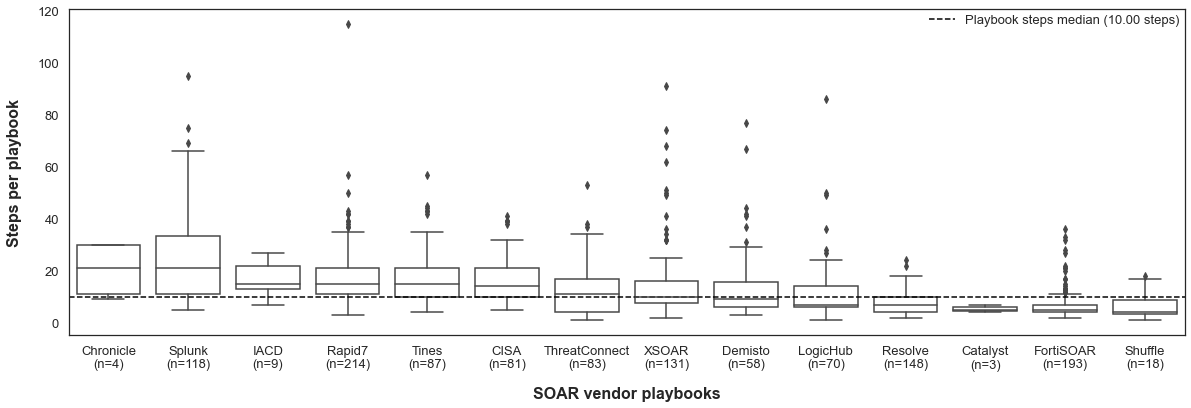

Playbook Mean: 13.82
Playbook Median: 10.00
Playbook 0.25 quartile: 6.00
Playbook 0.75 quartile: 17.00


In [142]:
# Set figure size
fig, ax = plt.subplots(figsize=(20, 6))

sns.set(style='white')

# Create boxplot
sns.boxplot(x='vendor', y='steps', data=df_result1, ax=ax, order=vendor_median_steps.index, boxprops={"facecolor": "white"})

# Add horizontal line for global median steps
median = df_result1['steps'].median()
ax.axhline(y=median, color='black', linestyle='--', label='Playbook steps median ({:.2f} steps)'.format(median))

# Add bar plot of automation on a second y-axis
#ax2 = ax.twinx()
#sns.lineplot(x='vendor', y='automation', data=df_automation, color='#005b96', ax=ax2, linewidth=3)

# Add horizontal line for global mean automation
#ax2.axhline(y=mean_automation, color='black', linestyle='-', label='Playbook automation mean ({:.2f}%)'.format(mean_automation))

# Set axis labels and font weights
ax.set_xlabel('SOAR vendor playbooks', fontsize=16, fontweight='bold')
ax.set_ylabel('Steps per playbook', fontsize=16, fontweight='bold')
#ax2.set_ylabel('Playbook automation (in %)', fontsize=16, fontweight='bold')

# Add padding to axis labels
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
#ax2.yaxis.labelpad = 13

# Set font size of tick labels
ax.tick_params(axis='both', labelsize=13)
#ax2.tick_params(axis='y', labelsize=13)

# Set x-axis labels with vendor counts
xtick_labels = ['{}\n(n={})'.format(label.get_text(), vendor_counts[label.get_text()]) for label in ax.get_xticklabels()]
ax.set_xticklabels(xtick_labels)

# Set y-axis limits for automation
#ax2.set_ylim(0, 100)

# Add legend
handles = [
    #plt.Line2D([], [], color='#005b96', alpha=0.3, label='Playbook automation by vendor (mean)'),
    #plt.Line2D([], [], color='black', linestyle='-', label='Playbook automation mean ({:.2f}%)'.format(mean_automation)),
    plt.Line2D([], [], color='black', linestyle='--', label='Playbook steps median ({:.2f} steps)'.format(median))
]
ax.legend(handles=handles, fontsize=13, borderaxespad=0., frameon=False)

            
# Save and show plot
plt.savefig('./charts/playbook-steps-automation.pdf', format='pdf', dpi=200, bbox_inches='tight')
plt.show()

# Print summary statistics
summary = df_result1['steps'].describe()
print('Playbook Mean: {:.2f}'.format(summary['mean']))
print('Playbook Median: {:.2f}'.format(summary['50%']))
print('Playbook 0.25 quartile: {:.2f}'.format(summary['25%']))
print('Playbook 0.75 quartile: {:.2f}'.format(summary['75%']))


## (6) The steps in the playbook are either for logic, utility, alerting/ticketing, investigation, or remediation (_Result 2_).

### (6.1) Group steps by actions and export results as CSV

In [143]:
# Access the column containing the text data
actions = df_SOV.groupby('action')['artifact'].agg(list)

# Export the results
actions.to_csv("./coding/6_1_actions_grouped.csv")


### (6.2) Read in coded step types and map them to the steps

In [144]:
df_step_types = pd.read_csv('./coding/6_2_action_types.csv', sep=';')

df_result2 = pd.merge(df_SOV, df_step_types[["action", "type"]], on='action', how='left')

df_result2.head()

,playbook_id,step_id,vendor,playbook_name,playbook_description,step_names,step_types,step_description,actuator,action,artifact,automation,step_name,step_type,type
0,p1,s1,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,starts,Start,start workflow,Platform,start,workflow,1,NaN,NaN,1
1,p1,s2,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,configurations,Configuration,configure workflow,Platform,configure,workflow,1,NaN,NaN,2
2,p1,s3,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,checks Type of Indicator,Condition,check type of indicator,Platform,check,type of indicator,1,NaN,NaN,"1,4"
3,p1,s4,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,blocks IP,Playbook execution,block IP,Platform,block,IP,1,NaN,NaN,5
4,p1,s5,FortiSOAR,Action (Type All) - Block Indicators,Blocks all types of indicators on the firewall...,blocks Domain,Playbook execution,block domain,Platform,block,domain,1,NaN,NaN,5


### (6.3) Plot step categories

                Frequency  Percentage
Logic              3770.0       22.41
Utility            3833.5       22.79
Ticketing          2344.0       13.93
Investigation      5943.0       35.33
Countermeasure      930.5        5.53


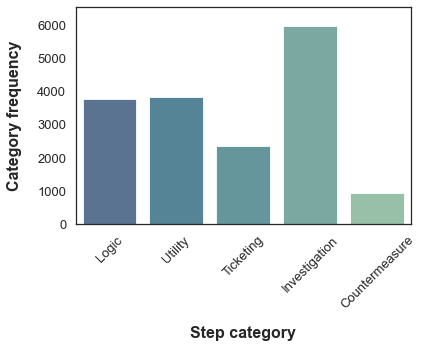

In [145]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group the DataFrame by the 'type' column and get the size of each group
grouped_types = df_result2.groupby('type').size()

# Convert the resulting Series to a dictionary
grouped_types_dict = grouped_types.to_dict()

# Initialize a new dictionary to hold the cleaned data
cleaned_dict = {}

# Loop over each key-value pair in the original dictionary
for key, value in grouped_types_dict.items():
    # Split the key string into an array of individual values
    key_arr = key.split(",")
    # Loop over each value in the key array
    for val in key_arr:
        # If the value is not already in the cleaned dictionary, initialize it to 0
        if val not in cleaned_dict:
            cleaned_dict[val] = 0
        # Add the group size divided by the number of values in the key array to the value in the cleaned dictionary
        cleaned_dict[val] = cleaned_dict[val] + value / len(key_arr)

# Sort the cleaned dictionary by key in ascending order
cleaned_dict = dict(sorted(cleaned_dict.items(), key=lambda x: int(x[0])))

# Convert the cleaned dictionary to a DataFrame, with the keys as the index and a single 'Frequency' column
df_tmp = pd.DataFrame.from_dict(cleaned_dict, orient='index', columns=['Frequency'])

# Rename the index values using a dictionary
df_tmp = df_tmp.rename(index={'1': 'Logic', '2': 'Utility', '3': 'Ticketing', '4': 'Investigation', '5': 'Countermeasure'})

# Print the first few rows of the resulting DataFrame
total_frequency = df_tmp['Frequency'].sum()

# add a new column called "Percentage"
df_tmp['Percentage'] = 0

# calculate the percentage value for each row and assign it to the "Percentage" column
for index, row in df_tmp.iterrows():
    percentage = round((row['Frequency'] / total_frequency) * 100,2)
    df_tmp.at[index, 'Percentage'] = percentage
    
print(df_tmp.head())

# Create a barplot using the cleaned DataFrame
ax = sns.barplot(x=df_tmp.index, y='Frequency', data=df_tmp, palette='crest_r', alpha=0.8)

# Set padding for the x- and y-axis labels
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

# Set y-axis limits for better visualization
ax.set_ylim([0, max(df_tmp['Frequency']) * 1.1])

# Set x- and y-axis labels and font sizes
ax.set_xlabel('Step category', fontsize=16, fontweight='bold')
ax.set_ylabel('Category frequency', fontsize=16, fontweight='bold')

# Set font size of tick labels and rotate x-axis tick labels for better visibility
ax.tick_params(axis='both', labelsize=13)
plt.xticks(rotation=45)

# Show the resulting plot
plt.show()


### (6.4) Print top actuators per step category

In [146]:
comprehension = {1: "Logic", 2: "Utility", 3: "Ticketing", 4: "Investigation", 5: "Countermeasure"}
actuator = df_result2.groupby('type')['actuator'].agg(list)

dictionary = {1: [], 2:[], 3:[],4:[], 5:[]}
for key, value in actuator.items():
    type_list = key.split(',')
    if len(type_list) == 1:
        dictionary[int(type_list[0])].extend(value)

for key, value in dictionary.items():
    counter = Counter(value)
    top_10 = [item for item, count in counter.most_common(20)]
    dictionary[key] = top_10
    print(f"{comprehension[key]}: {top_10}")
    

Logic: ['Platform', 'Human', 'Microsoft Teams', 'Splunk', 'Timers', 'cyops_utilities', 'ZScaler', 'API', 'Slack', 'Rapid7 InsightVM', 'Microsoft Office 365 Email', 'Sleep', 'PAN-OS', 'Windows Remote Management', 'Jira', 'Falco', 'PagerDuty', 'Fidelis Endpoint', 'Type Converter', 'Rapid7 InsightVM Console']
Utility: ['Platform', 'cyops_utilities', 'Type Converter', 'ExtractIt', 'JMESPath', 'JoinArray', 'Builtin', 'String Operations', 'Human', 'Python 3 Script', 'HTML', 'RegexExtract', 'Base64', 'Math', 'Microsoft Teams', 'JsonPath', 'Markdown', 'Storage', 'slacalculator', 'Datetime']
Ticketing: ['Platform', 'Microsoft Teams', 'Slack', 'Human', 'API', 'Jira', 'Builtin', 'Slack Messaging', 'Microsoft Office 365 Email', 'smtp', 'Chronicle', 'AddAttribute', 'Rapid7 InsightIDR', 'TagCreate', 'String Operations', 'McAfee ESM', 'Microsoft Office365 Email Security', 'EmailV2', 'ids', 'SMTP']
Investigation: ['Platform', 'Human', 'Jira', 'Rapid7 InsightVM', 'cyops_utilities', 'Recorded Future', '

### (6.5) Print top actions per step category

In [147]:
comprehension = {1: "Logic", 2: "Utility", 3: "Ticketing", 4: "Investigation", 5: "Countermeasure"}

action = df_result2.groupby('type')['action'].agg(list)

dictionary = {1: [], 2:[], 3:[],4:[], 5:[]}
for key, value in action.items():
    type_list = key.split(',')
    if len(type_list) == 1:
        dictionary[int(type_list[0])].extend(value)

for key, value in dictionary.items():
    counter = Counter(value)
    top_10 = [item for item, count in counter.most_common(5)]
    dictionary[key] = top_10
    print(f"{comprehension[key]}: {top_10}")
    

Logic: ['trigger', 'start', 'run', 'loop', 'decide']
Utility: ['show', 'extract', 'filter', 'format', 'configure']
Ticketing: ['send', 'add', 'post', 'notify', 'close']
Investigation: ['get', 'link', 'create', 'lookup', 'search']
Countermeasure: ['block', 'remove', 'execute', 'disable', 'quarantine']


### (6.6) Plot top artifacts per step category

In [148]:
comprehension = {1: "Logic", 2: "Utility", 3: "Ticketing", 4: "Investigation", 5: "Countermeasure"}

artifact = df_result2.groupby('type')['artifact'].agg(list)

dictionary = {1: [], 2:[], 3:[],4:[], 5:[]}
for key, value in artifact.items():
    type_list = key.split(',')
    for val in value:
        val1 = val.split(" ")
        for val2 in val1:
            if val2 != "workflow":
                dictionary[int(type_list[0])].append(nltk.stem.PorterStemmer().stem(val2.lower()))

for key, value in dictionary.items():
    counter = Counter(value)
    top_10 = [item for item, count in counter.most_common(10)]
    dictionary[key] = top_10
    print(f"{comprehension[key]}: {top_10}")

Logic: ['statu', 'playbook', 'condit', 'while', 'ip', 'email', 'file', 'hash', 'result', 'indic']
Utility: ['data', 'result', 'statu', 'url', 'summari', 'ip', 'email', 'domain', 'file', 'report']
Ticketing: ['statu', 'messag', 'email', 'ticket', 'quarantin', 'state', 'notif', 'note', 'done', 'host']
Investigation: ['file', 'ip', 'indic', 'incid', 'url', 'row', 'ticket', 'count', 'output', 'domain']
Countermeasure: ['ip', 'context', 'user', 'host', 'hash', 'account', 'domain', 'file', 'url', 'messag']


## (7) Playbooks are mostly built out of more than one step cluster (_Result 3_)

### (7.1) Prepare step clusters

In [149]:
def get_sorted_values(x):
    values = list(x.str.split(','))
    sorted_values = sorted(values)
    return ','.join(sorted_values)

# group dataframe by playbook_id and apply function to type column
df_playbook_types = df_result2[df_result2['type'].notna()]

df_playbook_types = df_playbook_types[df_playbook_types['type'].apply(lambda x: not "," in x)]

df_playbook_types = df_playbook_types.groupby('playbook_id').agg({'type': lambda x: ','.join(x.astype(str))})

# create new columns for each value from 1 to 5
for i in range(1, 6):
    df_playbook_types[i] = 0

# iterate over each row
for index, row in df_playbook_types.iterrows():
    # split the "type" column by ","
    types = row["type"].split(",")
    # calculate the frequency of each number using value_counts
    counts = pd.Series(types).value_counts()
    # update the respective columns using loc
    for col, val in counts.iteritems():
        df_playbook_types.loc[index, int(col)] = val

df_playbook_types['type_size'] = df_playbook_types['type'].apply(lambda x: len(set(x.split(','))))

df_playbook_types.drop('type', axis=1, inplace=True)

counts = (df_playbook_types.iloc[:, :-1] == 0).sum(axis=1).value_counts(normalize=True)
counts = counts.apply(lambda x: x * 100)

grouped = df_playbook_types.groupby('type_size').agg({col: 'sum' for col in df_playbook_types.columns[:-1]})

# Calculate the percentage of each value within a row

# Rename the columns and calculate the percentage of each value within a row
new_columns = {
    1: 'Logic',
    2: 'Utility',
    3: 'Ticketing',
    4: 'Investigation',
    5: 'Countermeasure'
}
grouped = grouped.rename(columns=new_columns).apply(lambda row: row / row.sum() * 100, axis=1)
grouped = grouped.drop(index=1)
grouped = grouped.sort_values(by='type_size', ascending=False)
grouped = grouped.rename(index={2: f'2 categ.\n ({round(counts[3],1)}%)', 3: f'3 categ.\n ({round(counts[2],1)}%)', 4: f'4 categ.\n ({round(counts[1],1)}%)', 5: f'5 categ.\n ({round(counts[0],1)}%)'})


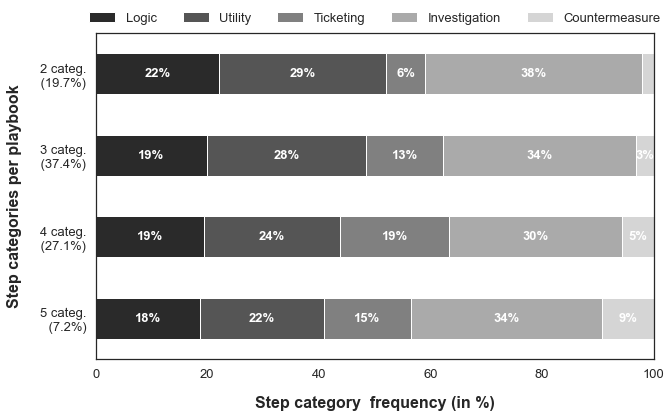

In [150]:
# Create the stacked bar plot
ax = grouped.plot.barh(stacked=True, figsize=(10,6),color=sns.color_palette('gray',5))


# Add data labels in percent
for rect in ax.containers:
    # Iterate over the rectangles in the container and add the label
    for r in rect:
        width = r.get_width()
        if width > 3:
            # Calculate the percentage and format the label
            label = f'{int(width)}%'
            # Add the label to the rectangle
            ax.annotate(label, xy=(r.get_x() + r.get_width() / 2, r.get_y() + r.get_height() / 2),
                        xytext=(0, 0), textcoords="offset points", color="white",
                        ha='center', va='center', fontsize=13, fontweight='bold')

            # Add padding to axis labels
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
# Set y-axis limits for automation
ax.set_xlim(0, 100)
# Set axis labels and font weights
ax.set_xlabel('Step category  frequency (in %)', fontsize=16, fontweight='bold')
ax.set_ylabel('Step categories per playbook', fontsize=16, fontweight='bold')

# Set font size of tick labels
ax.tick_params(axis='both', labelsize=13)


# Remove legend border
ax.legend(frameon=False)

# Move legend to top of the diagram
ax.legend(loc='upper center', fontsize=13, bbox_to_anchor=(0.5, +1.1), ncol=5, frameon=False)

plt.savefig('./charts/multi-purpose-playbooks.pdf', format='pdf', dpi=200, bbox_inches='tight')

# Show the plot
plt.show()
